In [66]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import time
from os import listdir

In [2]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [3]:
X.shape

(2065, 200, 200, 3)

In [37]:
def entropy(matrix):
    return shannon_entropy(matrix)   

In [38]:
img = X[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
glcm = greycomatrix(img, [30], [0], 256, symmetric=True, normed=True)
entropy(glcm)

1.634161403598633

In [14]:
glcm.shape

(256, 256, 1, 1)

In [39]:
def textual_features(img):
    Z = img
    Z = cv2.cvtColor(Z, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(Z, [30], [0], 256, symmetric=True, normed=True)
    cont = greycoprops(glcm, 'contrast')
    diss = greycoprops(glcm, 'dissimilarity')
    homo = greycoprops(glcm, 'homogeneity')
    eng = greycoprops(glcm, 'energy')
    corr = greycoprops(glcm, 'correlation')
    ASM = greycoprops(glcm, 'ASM')
    Ent = entropy(glcm)
    return [float(cont[0]), float(diss[0]), float(homo[0]), float(eng[0]), float(corr[0]), float(ASM[0]),float(Ent)]


In [40]:
def textual_transform(X,func,y):
    n=len(X)
    new_data = pd.DataFrame(index= range(n) ,columns =['contrast','dissimilarity','homogeneity','energy','correlation','ASM','Entropy'])
    new_data.fillna(0)
    for i,image in enumerate(X):
        feature = func(image)
        new_data.loc[i] = feature
    new_data['Tumor'] = y    
    return new_data    
    

In [41]:
txt_features = textual_transform(X, textual_features,y)

In [7]:
def casting(df,columns):
    for column in columns:
        df[column] = df[column].astype(float)
    return df   

In [44]:
txt_features = casting(txt_features,['contrast','dissimilarity','homogeneity','energy','correlation','ASM','Entropy'])

In [45]:
txt_features.dtypes

contrast         float64
dissimilarity    float64
homogeneity      float64
energy           float64
correlation      float64
ASM              float64
Entropy          float64
Tumor              int64
dtype: object

### Analysis :
We will try to inspect some patterns in the class of tumors and their differences with the normal images

In [11]:
txt_features.Tumor.value_counts()

1    1085
0     980
Name: Tumor, dtype: int64

In [49]:
columns =['contrast','dissimilarity','homogeneity','energy','correlation','ASM','Entropy']
tumor = txt_features[txt_features.Tumor==1][columns]
no_tumor = txt_features [txt_features.Tumor==0][columns]


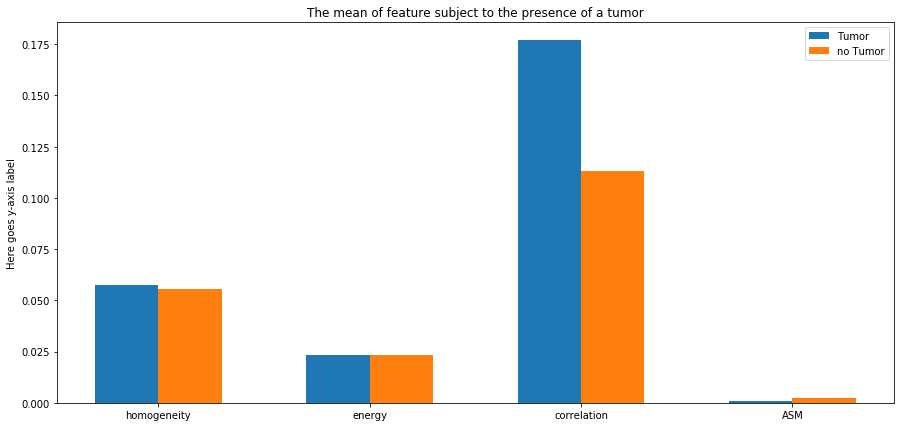

In [50]:
columns =['homogeneity','energy','correlation','ASM']
tumor_c = tumor[columns]
no_tumor_c = no_tumor[columns]
mean_tumor= pd.DataFrame(tumor_c.mean())
mean_tumor = mean_tumor.rename(columns={0:'mean'})
    
mean_notumor = pd.DataFrame(no_tumor_c.mean())
mean_notumor = mean_notumor.rename(columns={0:'meanno'})
    
ind = np.arange(4)

# Figure size
plt.figure(figsize=(15,7))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, mean_tumor['mean'], width, label='Tumor')
plt.bar(ind + width, mean_notumor['meanno'], width, label='no Tumor')

plt.ylabel('Here goes y-axis label')
plt.title('The mean of feature subject to the presence of a tumor')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('homogeneity','energy','correlation','ASM','Entropy'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()
    


### Correlation within each class :

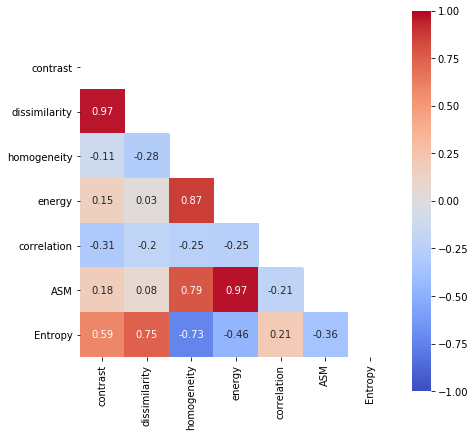

In [65]:
corr_tumor = tumor.corr()
matrix = np.triu(corr_tumor)
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(7,7))
sns.heatmap(corr_tumor,mask=matrix, annot=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square = True)



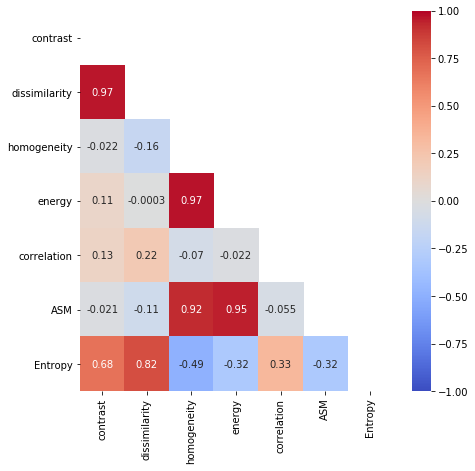

In [63]:
corr_notumor = no_tumor.corr()
matrix = np.triu(corr_notumor)
plt.figure(figsize=(7,7))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_notumor,mask=matrix, annot=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

#### Stadarization :

In [52]:
def standardize(x):
    centered_data = x - np.mean(x, axis=0)
    std_data = centered_data / np.std(x, axis=0)
    
    return std_data

In [53]:
columns =['contrast','dissimilarity','homogeneity','energy','correlation','ASM','Entropy']
features = txt_features[columns]
features_scaled = standardize(features)
scaled_df = features_scaled
scaled_df['Tumor'] = y

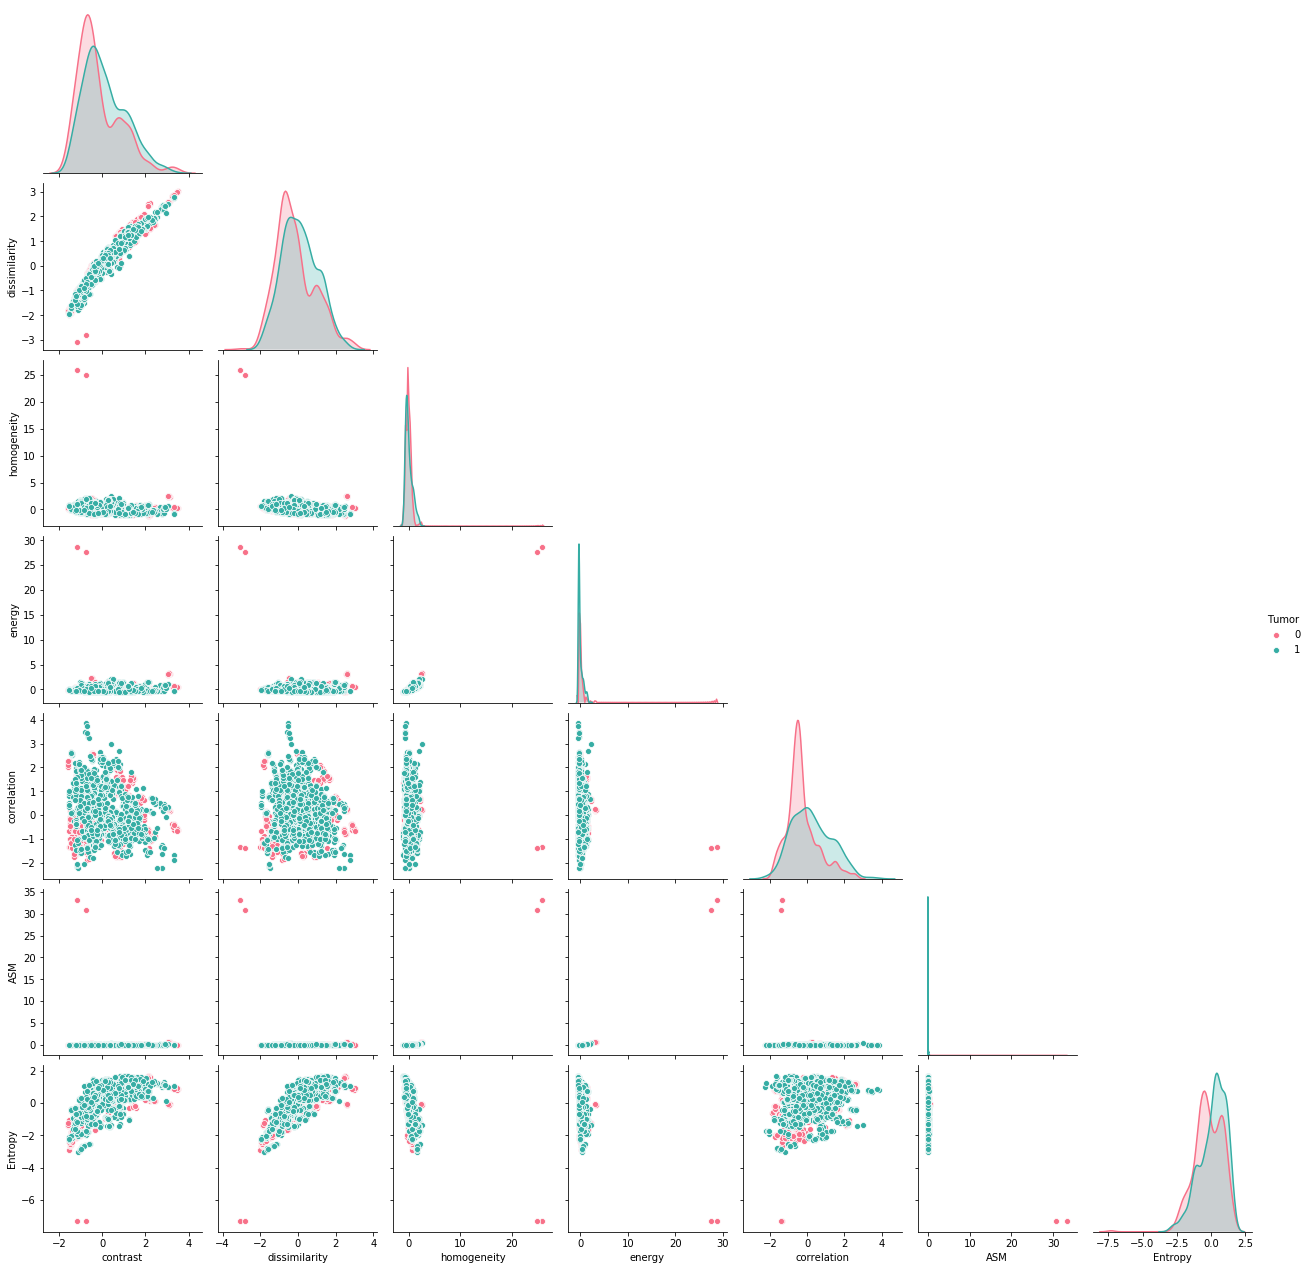

In [54]:
g = sns.pairplot(scaled_df, hue="Tumor",palette='husl',corner=True)


### Detecting outliers : 


In [68]:
Sorted =scaled_df.sort_values('ASM', axis=0, ascending=False)

In [69]:
Sorted

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,Entropy,Tumor
833,3.079928,2.575067,2.553391,3.309821,0.221274,0.571336,-0.130642,0
293,3.094821,2.591519,2.454203,3.188719,0.221391,0.534151,-0.109199,0
676,3.043338,2.554411,2.458857,3.171698,0.231585,0.529015,-0.074296,0
624,3.055117,2.573873,2.427030,3.170091,0.205087,0.528532,-0.077073,0
1266,3.061442,2.579346,2.421556,3.128722,0.250300,0.516147,-0.092100,0
...,...,...,...,...,...,...,...,...
1247,2.138525,2.486907,-1.121560,-0.502105,-0.776960,-0.057317,1.636976,0
31,0.807565,1.238007,-1.076193,-0.502432,-0.983851,-0.057323,1.645958,1
1302,0.995975,1.430384,-1.106186,-0.503418,-1.690936,-0.057341,1.643367,1
562,1.114292,1.505054,-1.048928,-0.506715,-0.754444,-0.057400,1.667153,1


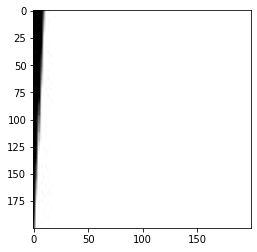

In [70]:
plt.imshow(X[334])

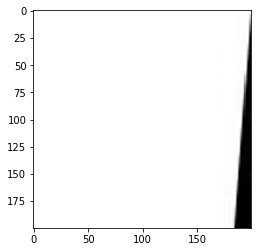

In [71]:
plt.imshow(X[358])

## deleting outliers:

In [72]:
scaled_df = scaled_df.drop([334,358])

KeyError: '[334 358] not found in axis'

In [73]:
scaled_df.shape

(2063, 8)

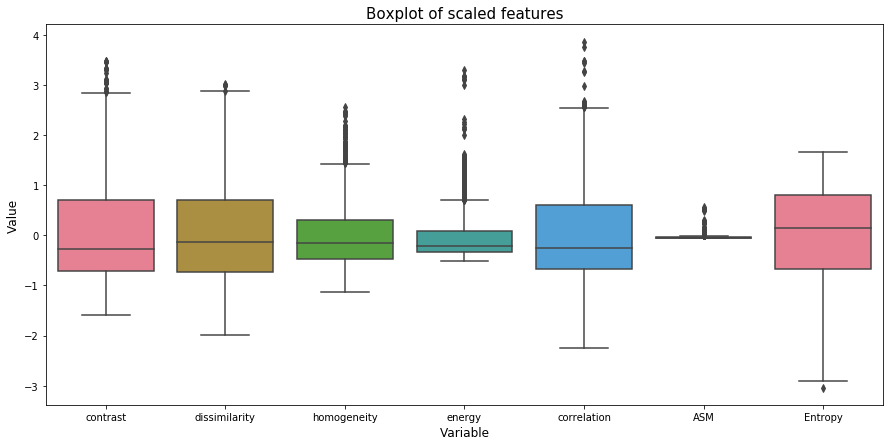

In [74]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.boxplot(x="variable", y="value", data=pd.melt(scaled_df[columns]), palette=sns.color_palette("husl"))
plt.xlabel("Variable", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Boxplot of scaled features", fontsize=15)

plt.show()

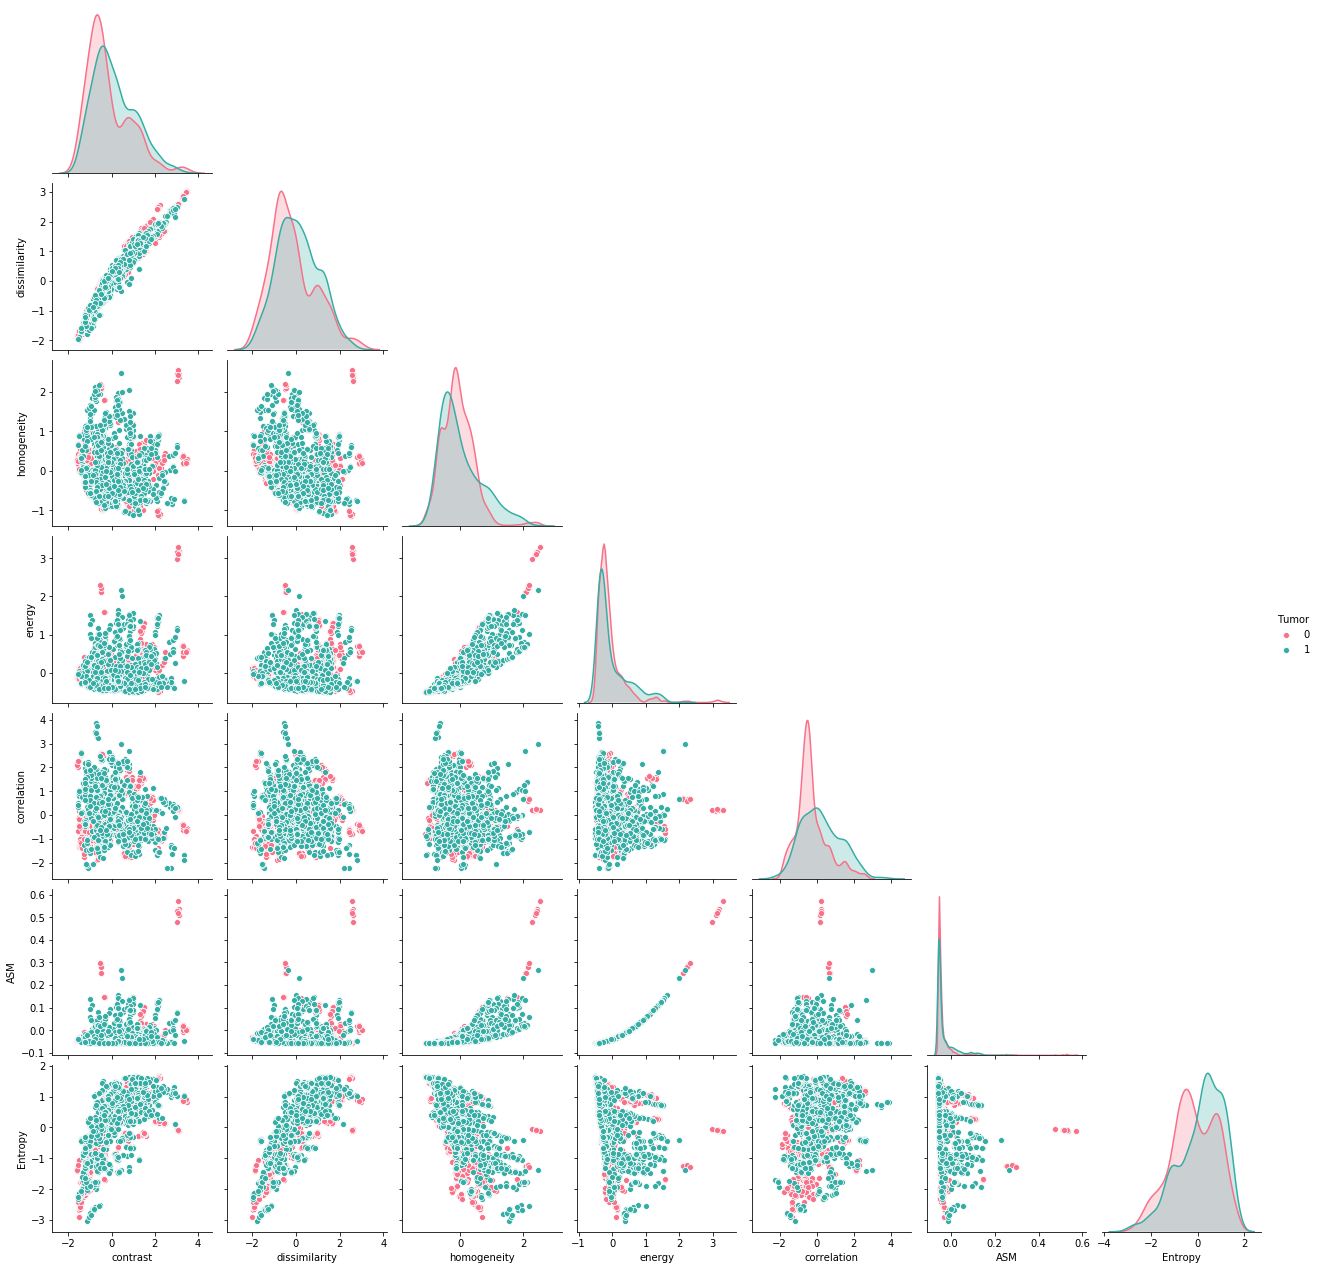

In [75]:
#### Replotting :
g = sns.pairplot(scaled_df, hue="Tumor",palette='husl',corner=True)


## PCA


#### Dimension reduction to 2 components so that we can visualize the clustering:

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
features_scaled=scaled_df[columns]
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf.head()

,principal component 1,principal component 2,principal component 3
0,-0.263408,-0.165386,-0.405978
1,-0.582610,0.780546,-0.615548
2,-0.599562,1.255455,-0.077366
3,0.960180,2.176675,0.417257
4,1.647649,-0.514502,-0.077411


#### Explained variance :

In [77]:
pca.explained_variance_ratio_

array([0.57469769, 0.25556206, 0.1435974 ])

#### Components :

In [78]:
pca.components_

array([[ 0.57170551,  0.60350799, -0.12694196,  0.01152361,  0.07476528,
         0.0032703 ,  0.53580157],
       [-0.28204217, -0.14920609, -0.2654763 , -0.20550699,  0.83590141,
        -0.01777285,  0.29399308],
       [ 0.22126441,  0.10867133,  0.5964032 ,  0.48331559,  0.50838378,
         0.04687334, -0.29881547]])

In [79]:
### Adding the target
principalDf['target'] = scaled_df['Tumor']
principalDf.head()

,principal component 1,principal component 2,principal component 3,target
0,-0.263408,-0.165386,-0.405978,0.0
1,-0.582610,0.780546,-0.615548,1.0
2,-0.599562,1.255455,-0.077366,1.0
3,0.960180,2.176675,0.417257,1.0
4,1.647649,-0.514502,-0.077411,1.0


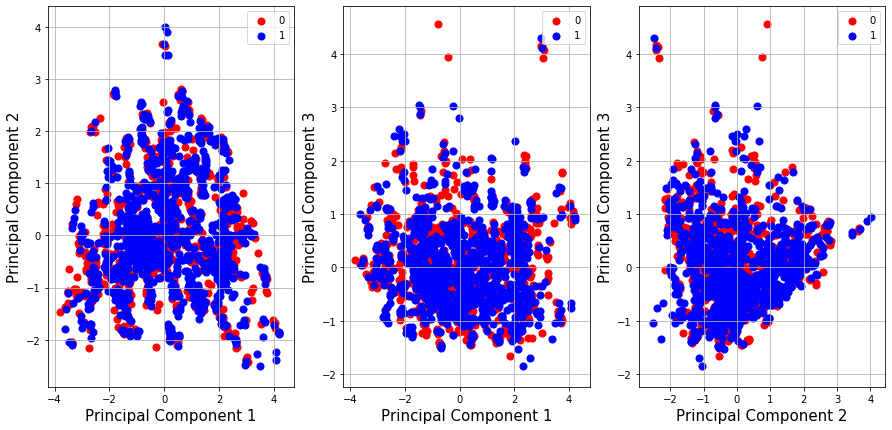

In [81]:
##### Plotting :
fig,axes = plt.subplots(1,3,figsize = (15,7))
   


axes[0].set_xlabel('Principal Component 1', fontsize = 15)
axes[0].set_ylabel('Principal Component 2', fontsize = 15)

axes[1].set_xlabel('Principal Component 1', fontsize = 15)
axes[1].set_ylabel('Principal Component 3', fontsize = 15)

axes[2].set_xlabel('Principal Component 2', fontsize = 15)
axes[2].set_ylabel('Principal Component 3', fontsize = 15)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    axes[0].scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
    axes[1].scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
    axes[2].scatter(principalDf.loc[indicesToKeep, 'principal component 2']
               , principalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
                , s = 50)
for i in range(3) :   
    axes[i].legend(targets)
    axes[i].grid()
    


### Scatter features versus target:

Here we will try to inspect the separability of each feature subject to the target value:

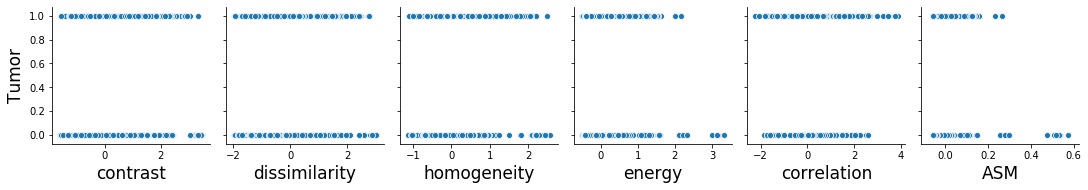

In [48]:
scatter_response = sns.pairplot(scaled_df, y_vars=["Tumor"],x_vars=columns ,kind="scatter")

we can see that we have a problem of separability for all the features. Some method will not be accurate when applying classification on this data shuch as Logistic regression. We have to think about applying an SVM with the kernel method so that we can find a mapping space where separability is feasible.

## Machine learning :

### logistic regression:

In [57]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
import sklearn as sk
X = scaled_df[columns]
y = scaled_df['Tumor']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3,random_state=1)
clf = LogisticRegressionCV(cv=5, random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[189  95]
 [102 233]]
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       284
           1       0.71      0.70      0.70       335

    accuracy                           0.68       619
   macro avg       0.68      0.68      0.68       619
weighted avg       0.68      0.68      0.68       619



#### SVM :

In [58]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[197  87]
 [107 228]]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       284
           1       0.72      0.68      0.70       335

    accuracy                           0.69       619
   macro avg       0.69      0.69      0.69       619
weighted avg       0.69      0.69      0.69       619



In [59]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[222  62]
 [ 65 270]]
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       284
           1       0.81      0.81      0.81       335

    accuracy                           0.79       619
   macro avg       0.79      0.79      0.79       619
weighted avg       0.80      0.79      0.79       619



In [61]:
from sklearn import svm
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[234  50]
 [142 193]]
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       284
           1       0.79      0.58      0.67       335

    accuracy                           0.69       619
   macro avg       0.71      0.70      0.69       619
weighted avg       0.72      0.69      0.69       619



In [62]:
from sklearn import svm
clf = svm.SVC(kernel='sigmoid')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[116 168]
 [156 179]]
              precision    recall  f1-score   support

           0       0.43      0.41      0.42       284
           1       0.52      0.53      0.52       335

    accuracy                           0.48       619
   macro avg       0.47      0.47      0.47       619
weighted avg       0.47      0.48      0.48       619



In [65]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(1)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test, rfc_pred))

[[241  43]
 [ 63 272]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       284
           1       0.86      0.81      0.84       335

    accuracy                           0.83       619
   macro avg       0.83      0.83      0.83       619
weighted avg       0.83      0.83      0.83       619



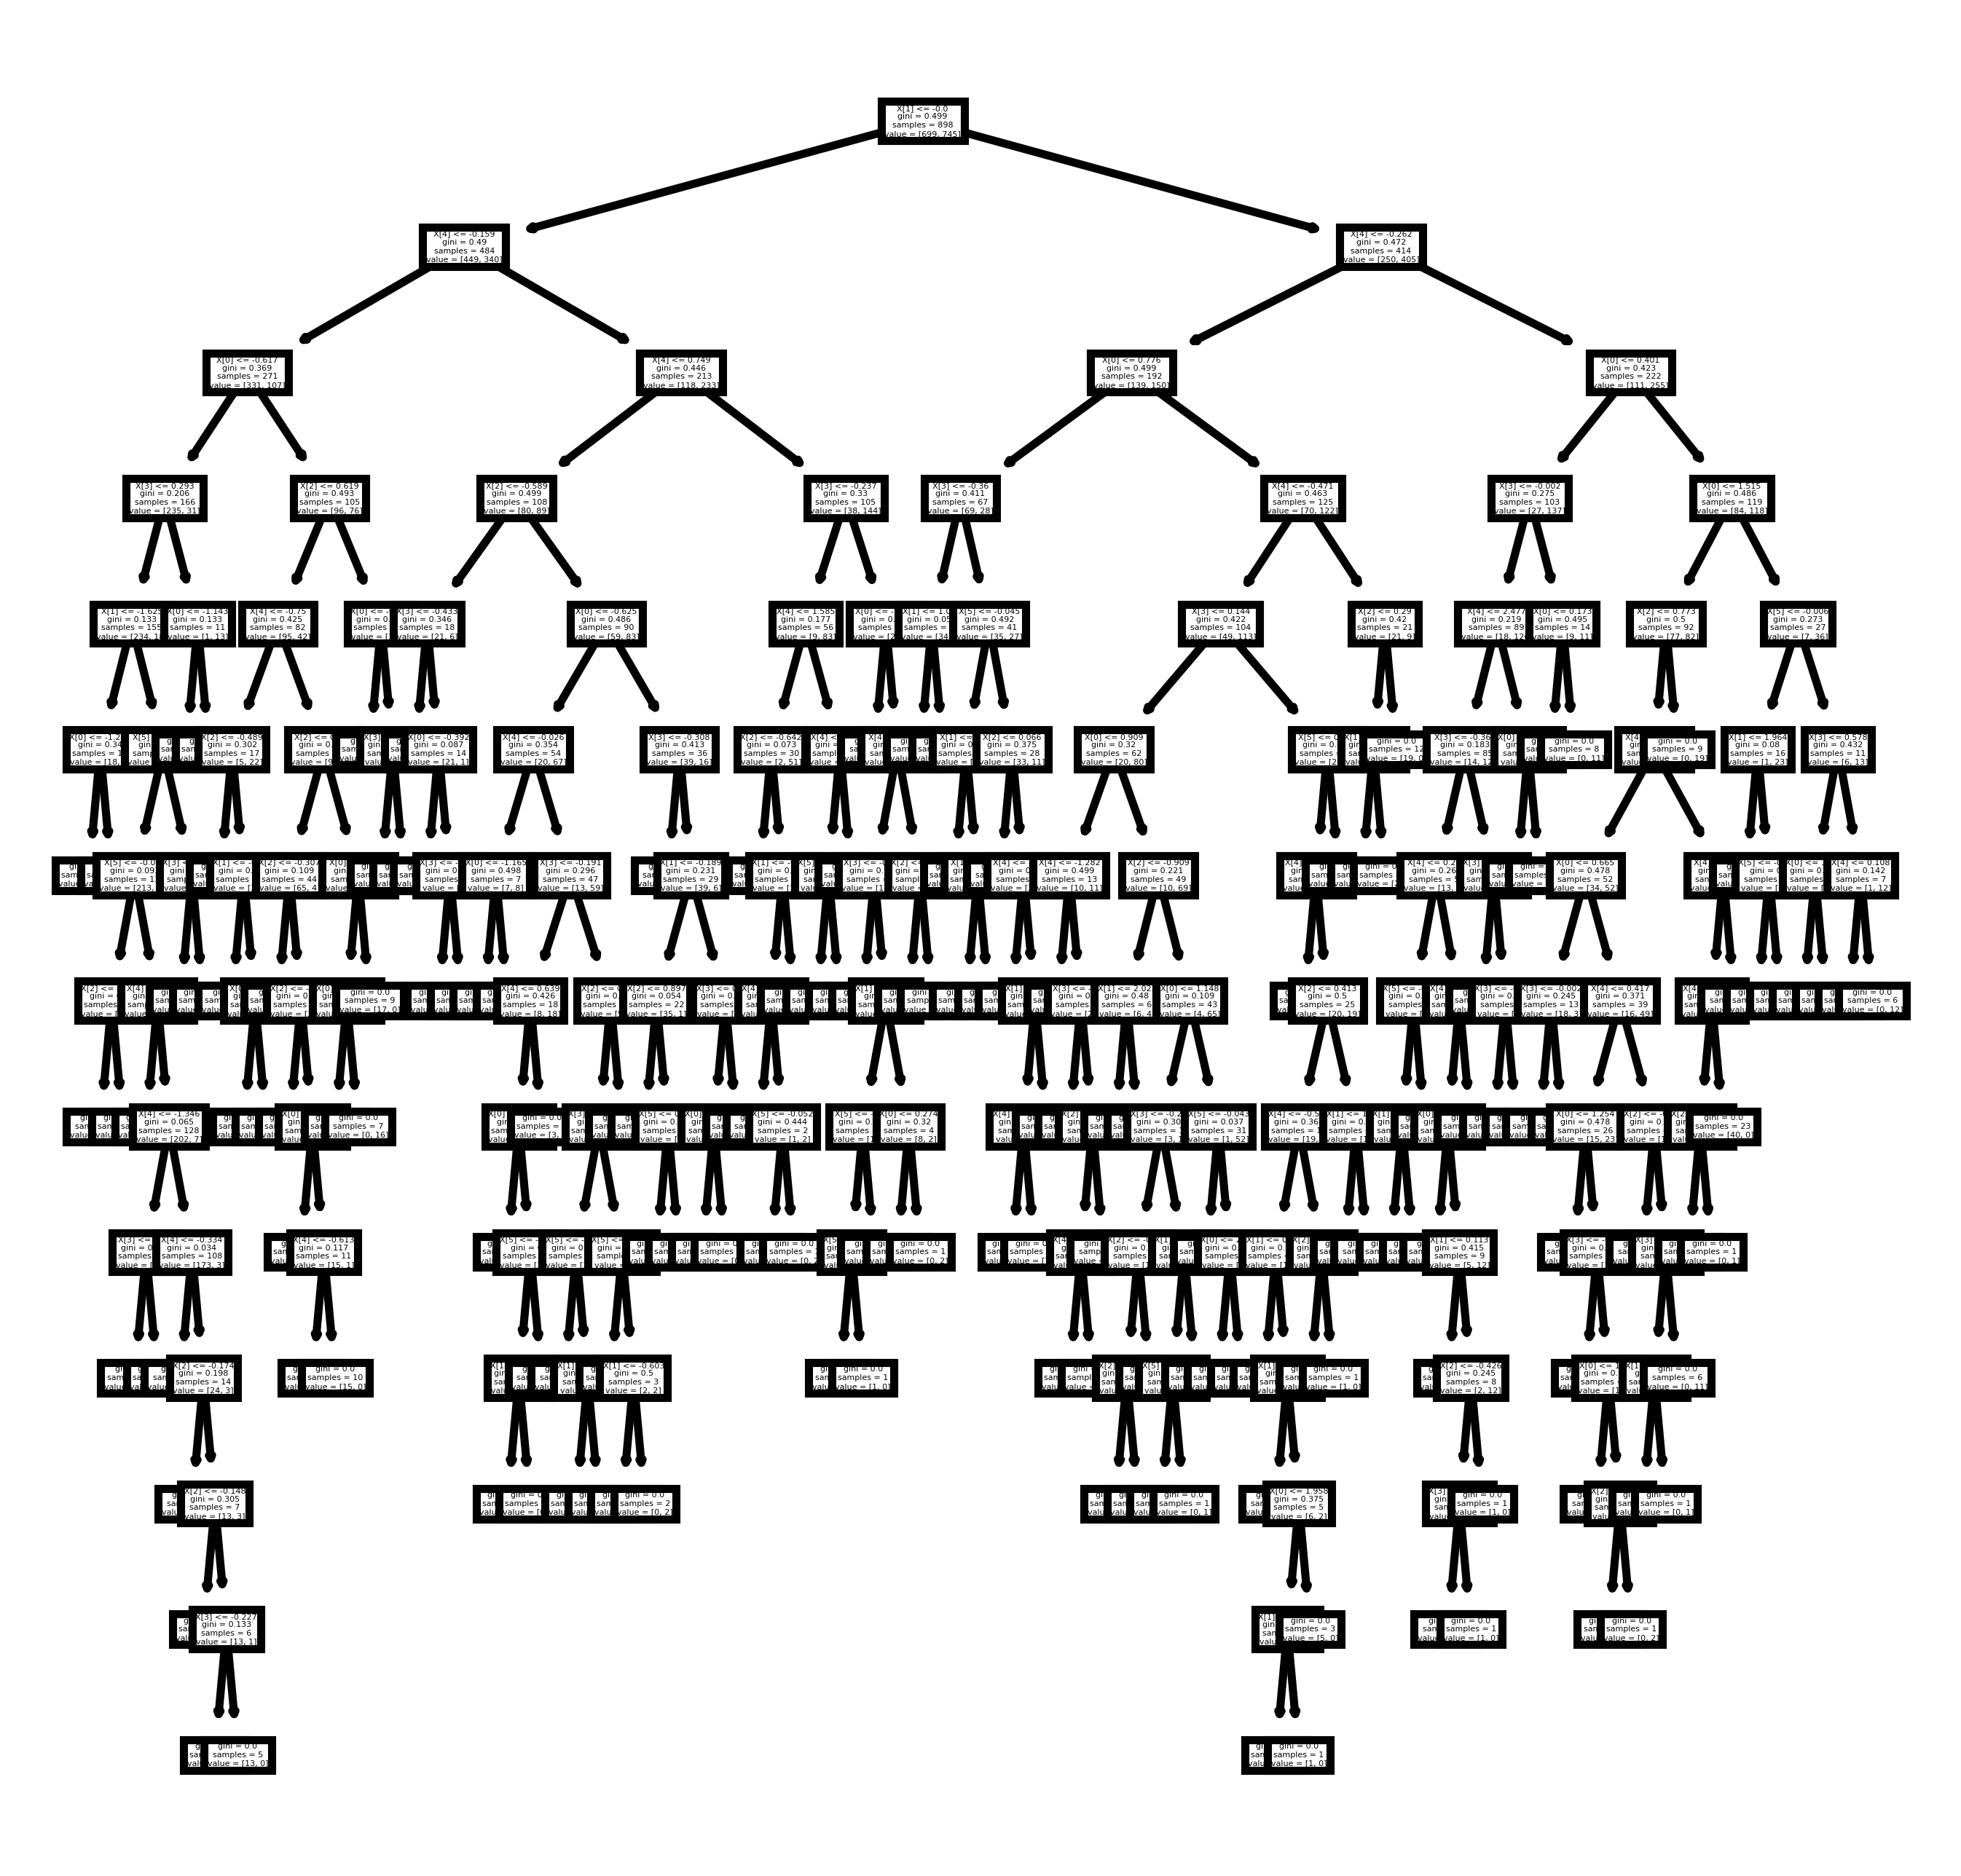

In [69]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc.estimators_[0])
fig.savefig('rf_individualtree.png')
